# Poisson 2D implementado en nubes de puntos.

Función que calcula una aproximación a la solución de la ecuación de Poisson en 2D utilizando Diferencias Finitas Generalizadas en nubes de puntos.

El problema que se resuelve es:

\begin{align}
\nabla^2 \phi = f
\end{align}

El número de vecinos varia dependiendo del nodo.

### Parámetros de entrada
    p           m x 2       double      Matriz con las coordenadas de los m nodos.
    pb          o x 2       double      Matriz con las coordenadas de los nodos frontera.
    vec         mxnvec      double      Matriz con la correspondencia de los vecinos de cada nodo.
    phi                     function    Función declarada con la condición de frontera.
    f                       function    Función declarada con el lado derecho de la ecuación.

### Parámetros de salida
    phi_approx  m x 1       double      Vector con la aproximación calculada por el método.
    phi_exacta  m x 1       double      Vector con la solución exacta del problema.

## Inicialización del Problema
Se inicializa lo necesario para el problema:


1.   Se importan las librerías necesarias.
2.   Se cargan los datos de la región.
3.   Se definen las condiciones de frontera.

### Importación de Librerias
En esta parte se importan las librerias necesarias para ejecutar todo el código. En particual se importan:

*   **numpy**. Para poder hacer la mayor parte de los cálculos numéricos.
*   **math**. Permite hacer uso de diferentes funciones matemáticas.
*   **matplotlib**. Para hacer las gráficas necesarias.
*   **scipy.io**. Para usar una gran cantidad de funciones matemáticas.
*   **sys**. Para poder usar códigos en otras carpetas.
*   **Gammas**. Rutinas para el cálculo de Gammas del Método de Diferencias Finias Generalizadas.
*   **Errores**. Rutinas para calcular el Error Cuadrático Medio.
*   **Graficar**. Rutinas para graficar los resultados.

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io
import sys
sys.path.insert(0, '../Generales/')
from Gammas import Gammas_cloud as Gammas
from Errores import ECM_cloud_static as ECM
from Graficar import graph_cloud_static as Graph
from scipy.io import loadmat

### Se cargan los datos de la region

En esta parte se cargan los datos de la region desde un archivo .mat y se guardan en sus respectivas variables $p$, $pb$ y $vec$.

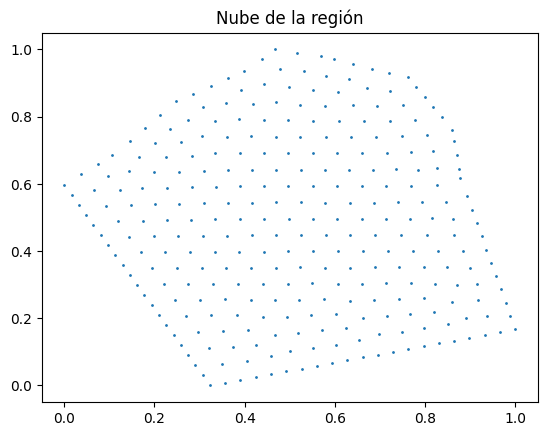

In [4]:
# Nube para trabajar
nube = 'CAB_1'

# Se cargan todos los datos desde el archivo
mat = scipy.io.loadmat('../Regiones/Nubes/' + nube + '.mat')

# Se guardan los datos de los nodos
p   = mat['p']
pb  = mat['pb']
vec = mat['vec']

# Se imprimen los nodos para asegurarnos de que se cargan correctamente.
plt.scatter(p[:,0],  p[:,1],  s = 1)
plt.title('Nube de la región')
plt.show()

### Se definen las condiciones de frontera

Las condiciones de frontera setán definidas como:
\begin{align}
  \phi = 2e^{2x+y}
\end{align}

\begin{align}
  f = 10e^{2x+y}
\end{align}

In [5]:
def phi(x,y):
  fun = 2*math.exp(2*x+y)
  return fun

def f(x,y):
  fun = 10*math.exp(2*x+y)
  return fun

## Diferencias Finitas Generalizadas
En esta parte se implementa el método de Diferencias Finitas Generalizadas sobre nubes de puntos.

In [6]:
def Poisson_Cloud(p, pb, vec, phi, f):
  m        = len(p[:,0])                                                         # Se encuentra el número de nodos.
  mf       = len(pb[:,0])                                                        # Se encuentra el número de nodos de frontera.
  mm       = len(p[np.arange(mf,m),0])                                           # Se encuentra el número de nodos interiores.
  err      = 1                                                                   # Se inicializa el error con 1.
  tol      = np.finfo(float).eps                                                 # La tolerancia será eps.
  phi_ap   = np.zeros([m])                                                       # Se inicializa phi_ap con ceros.
  phi_ex   = np.zeros([m])                                                       # Se inicializa phi_ex con ceros.

  for i in np.arange(mf):                                                        # Para cada uno de los nodos de frontera.
    phi_ap[i]   = phi(pb[i, 0],   pb[i, 1])                                      # Se agrega la condición de frontera.

  # Ahora, se calculan las Gammas
  L = np.vstack([[0], [0], [2], [0], [2]])                                       # Se asignan los valores para el operador diferencial.
  Gamma = Gammas(p, pb, vec, L)                                                  # Se calculan las Gammas.

  while err >= tol:                                                              # Mientras que el error sea mayor que la tolerancia.
    err = 0                                                                      # Error se hace cero para poder actualizar.
    for i in np.arange(mf, m):                                                   # Para cada uno de los nodos interiores.
      phitemp = 0                                                                # phitemp se hace cero.
      nvec = sum(vec[i,:] != 0)                                                  # Se calcula el número de vecinos que tiene el nodo.
      for j in np.arange(1,nvec+1):                                              # Para cada uno de los vecinos.
        phitemp = phitemp + Gamma[i, j]*phi_ap[int(vec[i, j-1])-1]               # Se calcula hacen diferencias finitas.

      t = (f(p[i, 0], p[i, 1]) - phitemp)/Gamma[i,0]                             # Se calcula el valor de phi_ap en el nodo central.
      err = max(err, abs(t - phi_ap[i]));                                        # Se calcula el error.
      phi_ap[i] = t;                                                             # Se asigna el valor calculado previamente.

    for i in range(m):                                                           # Para cada uno de los nodos.
      phi_ex[i] = phi(p[i,0], p[i,1])                                            # Se coloca la solución exacta.

  return phi_ap, phi_ex

## Ejecución

En esta parte se ejecutan los códigos necesarios para resolver el problema y se grafican las soluciones.

In [7]:
phi_ap, phi_ex = Poisson_Cloud(p, pb, vec, phi, f)

El error cometido para el método es de:  0.0004428205347789338


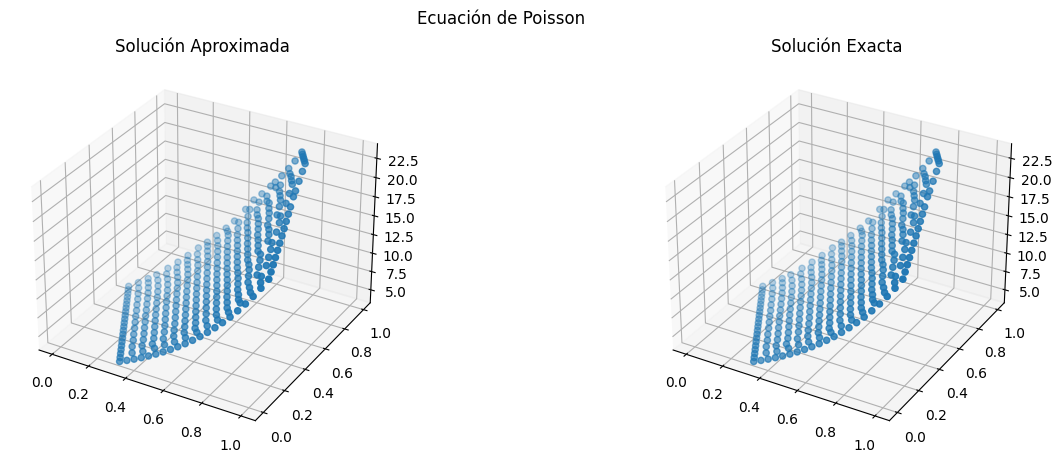

In [8]:
er = ECM(p, vec, phi_ap, phi_ex)
print('El error cometido para el método es de: ', er)
Graph(p, phi_ap, phi_ex)